In [9]:
import dataset_rad as dataset
import loader
import random 
from tqdm import tqdm
from torch.utils.data import DataLoader

import torch
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from encoder import *

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
def get_file_radiation(ind, items, log_=False):
    pc = np.load(items[ind])
    if log_:
        pv = np.log10(pc+np.random.rand(pc.shape)*0.001)
    pars = [float(p) for p in items[ind].split('.np')[0].split('/')[-1].split('_')[1:]]
    return torch.Tensor(pars).float(), torch.from_numpy(pc).float()

In [11]:
path = "/bigdata/hplsim/aipp/Anna/FEL/gaussian_init/radiation/training_data_test"

onlyfiles = [path+'/'+f for f in listdir(path) if isfile(join(path, f))]

dataset_tr = dataset.PCDataset(onlyfiles, get_file_radiation,
                               num_files=-1, normalize=True, log_=False)

Total number of files:  16807


In [12]:
dataset_tr.vmin = torch.load('vmin_outputs.pt')
dataset_tr.vmax = torch.load('vmax_outputs.pt')
dataset_tr.vmin_p = torch.load('vmin_params.pt')
dataset_tr.vmax_p = torch.load('vmax_params.pt')

print(dataset_tr.vmin_p)
print(dataset_tr.vmax_p)

tensor([-5.0000e-04, -1.0000e-04, -5.0000e-04, -1.0000e-04,  1.7000e+02])
tensor([5.0000e-04, 1.0000e-04, 5.0000e-04, 1.0000e-04, 2.4000e+02])


In [13]:
path = "/bigdata/hplsim/aipp/Anna/FEL/gaussian_init/radiation/validation_data_test"
onlyfiles = [path+'/'+f for f in listdir(path) if isfile(join(path, f))]

dataset_val = dataset.PCDataset(onlyfiles, get_file_radiation, num_files=-1)

Total number of files:  1024


In [14]:
vmin = dataset_tr.vmin
vmax = dataset_tr.vmax
vmin_p = dataset_tr.vmin_p
vmax_p = dataset_tr.vmax_p

# Dataset

Let's test our implementation 

In [15]:
_,x = dataset_tr[0]
x = x.numpy()
x_ = decode(*encode(x,20,5,0.05))

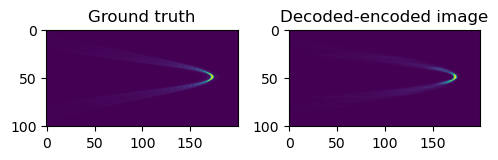

In [16]:
fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(x)
ax[0].set_title('Ground truth')
ax[1].imshow(x_)
ax[1].set_title('Decoded-encoded image')
fig.tight_layout()

### Pre-process dataset

We now want to create a dataset for learning a model from particle's parameters $y$
to resulting parabolas $z$, i.e. $\Phi: Y \rightarrow Z$

In [18]:
# training data. Converting might take a while, so better save it afterwards for quick re-using.
if not isfile('proc_data_tr'):
    proc_data_tr = []
    save = True
    convert_params = {'int_distance': 20, 'num_pars': 5, 'threshold': 0.05}

    for y,x in tqdm(dataset_tr):
        # normalize image and parameters
        y = (y - vmin_p) / (vmax_p - vmin_p)
        x = (x - vmin) / (vmax - vmin)

        params, vals = encode(x.numpy(),**convert_params)    
        proc_data_tr.append((torch.tensor(params), 
                             torch.tensor(vals), 
                             torch.tensor(y), 
                             torch.tensor(x)))

    if save:
        torch.save(proc_data_tr, 'proc_data_tr')

In [19]:
if not isfile('proc_data_val'):
    proc_data_val = []
    for y,x in tqdm(dataset_val):
        # normalize image and parameters
        y = (y - vmin_p) / (vmax_p - vmin_p)
        x = (x - vmin) / (vmax - vmin)

        params, vals = encode(x.numpy(),**convert_params)    
        proc_data_val.append((torch.tensor(params), 
                             torch.tensor(vals), 
                             torch.tensor(y), 
                             torch.tensor(x)))

    if save:
        torch.save(proc_data_val, 'proc_data_val')

# Learning

In [20]:
import torch
from torch import nn

from torch import nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torch.nn.functional as F

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [27]:
class Model(pl.LightningModule):
    """ 
    Simple 2-MLP model to predict parabola parameters and parabola values
    """
    def __init__(self, lr, pmax, pmin):
        super().__init__()
        self.param_net = nn.Sequential(
            nn.Linear(5,32), nn.ReLU(), 
            nn.Linear(32,64), nn.ReLU(), 
            nn.Linear(64,5*3),
        )
        
        self.val_net = nn.Sequential(
            nn.Linear(5,32), nn.ReLU(), 
            nn.Linear(32,128), nn.ReLU(), 
            nn.Linear(128,5*101),
        )
        # to normalize parabola's parameters
        self.pmax, self.pmin = pmax, pmin
        
        self.par_loss = nn.L1Loss()
        self.val_loss = nn.MSELoss()
        self.lr = lr
    
    def forward(self, x):
        p = self.param_net(x).view(-1,5,3)
        v = self.val_net(x).view(-1,5,101)
        return p,v
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return {"optimizer": optimizer}
    
    def loss(self, batch):
        params, vals, y, _ = batch
        params = (params - self.pmin) / (self.pmax - self.pmin)
        pred_p, pred_v = self(y.float())
        return self.par_loss(params.float(), pred_p) + self.val_loss(vals.float(), pred_v)
    
    def training_step(self, batch, batch_idx):
        loss = self.loss(batch)                             
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('test_loss', loss)

In [22]:
loader_tr = DataLoader(torch.load('proc_data_tr'), batch_size=32)
loader_val = DataLoader(torch.load('proc_data_val'), batch_size=32)

In [23]:
# for min-max normalization of parabola's parameters
pmax = torch.cat([x[0] for x in loader_tr.dataset]).max().item()
pmin = torch.cat([x[0] for x in loader_tr.dataset]).min().item()

In [28]:
model = Model(1e-4, pmax, pmin).float()

In [29]:
trainer = pl.Trainer(accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                     devices='auto',
                     max_epochs=50)

Multiprocessing is handled by SLURM.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, loader_tr, loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | param_net | Sequential | 3.3 K 
1 | val_net   | Sequential | 69.6 K
2 | par_loss  | L1Loss     | 0     
3 | val_loss  | MSELoss    | 0     
-----------------------------------------
72.8 K    Trainable params
0         Non-trainable params
72.8 K    Total params
0.291     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Testing

In [32]:
model.cuda()

Model(
  (param_net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=15, bias=True)
  )
  (val_net): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=505, bias=True)
  )
  (par_loss): L1Loss()
  (val_loss): MSELoss()
)

In [33]:
batch = next(iter(loader_val))
params, vals, y, x = batch
params = (params - model.pmin) / (model.pmax - model.pmin)
pred_p, pred_v = model(y.float().cuda())

In [34]:
pred_p = (pred_p * (model.pmax - model.pmin) + model.pmin).cpu().detach().numpy()
pred_v = pred_v.cpu().detach().numpy()

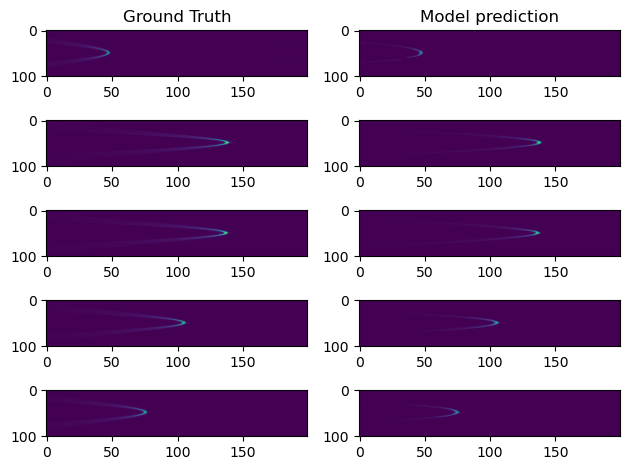

In [35]:
k = random.choice(list(range(32)))
x_ = decode(pred_p[k], pred_v[k])

fig, ax = plt.subplots(5,2)

for i in range(5):
    k = random.choice(list(range(32)))
    x_ = decode(pred_p[k], pred_v[k]) 
    ax[i,0].imshow(x[k], vmin=0, vmax=1, aspect = 'auto')
    ax[i,1].imshow(x_, vmin=0, vmax=1, aspect = 'auto')
    
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Model prediction')

fig.tight_layout()